from https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py#L33-L53

see also http://pytorch.org/tutorials/beginner/data_loading_tutorial.html

http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html



In [46]:
import torch 
import torch.nn as nn
from torchvision import datasets, models, transforms, utils
from torch.autograd import Variable
import torch.nn.functional as F

import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
num_epochs = 50
batch_size = 10
learning_rate = 0.001
dropout = 0.5
num_classes = 6

In [26]:
model_name = "cnn_pytorch.pkl"
model_exists = False

In [30]:
data_dir = 'data'

data_transforms = {
    'train': transforms.Compose([
        transforms.Scale((224,224)),
        # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor
        # of shape (C x H x W) in the range [0.0, 1.0].
        transforms.ToTensor(),
        # https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/6
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.Scale((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
image_datasets

{'test': <torchvision.datasets.folder.ImageFolder at 0x7fc595648f28>,
 'train': <torchvision.datasets.folder.ImageFolder at 0x7fc58e345fd0>}

In [64]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True)
              for x in ['train', 'test']}
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fc5952c5b70>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fc5952c5ac8>}

In [65]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
dataset_sizes

{'test': 1775, 'train': 7096}

In [66]:
class_names = image_datasets['train'].classes
class_names

['climbing', 'cycling', 'gymnastics', 'rowing', 'skating', 'xc_skiing']

In [18]:
class Convnet (nn.Module):
    
    def __init__(self):
        super(Convnet, self).__init__()
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding = 1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding = 1)
        self.fc1 = nn.Linear(32 * 56 * 56, 256)
        self.out = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = F.relu(F.batch_norm(self.conv1(x)))
        x = F.max_pool2d(F.relu(F.batch_norm(self.conv2(x)), 2))
        x = F.relu(F.batch_norm(self.conv3(x)))
        x = F.max_pool2d(F.relu(F.batch_norm(self.conv4(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.dropout(F.relu(self.fc1(x)), dropout)
        x = self.out(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



In [19]:
cnn = Convnet()
print(cnn)

Convnet (
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear (100352 -> 256)
  (out): Linear (256 -> 6)
)


In [20]:
params = list(cnn.parameters())
[p.size() for p in params]

[torch.Size([32, 3, 3, 3]),
 torch.Size([32]),
 torch.Size([32, 32, 3, 3]),
 torch.Size([32]),
 torch.Size([32, 32, 3, 3]),
 torch.Size([32]),
 torch.Size([32, 32, 3, 3]),
 torch.Size([32]),
 torch.Size([256, 100352]),
 torch.Size([256]),
 torch.Size([6, 256]),
 torch.Size([6])]

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [22]:
for epoch in range(1):
    
    for i, (images, labels) in enumerate(dataloaders["train"]):
        images = Variable(images)
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, dataset_sizes["train"]//batch_size, loss.data[0]))



NameError: name 'train_dataset' is not defined

In [25]:
 print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, dataset_sizes["train"]//batch_size, loss.data[0]))


Epoch [1/5], Iter [100/709] Loss: 1.8029


In [27]:
torch.save(cnn.state_dict(), model_name)

In [37]:
# Test the Model
cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0

total = 0
for (images, labels) in dataloaders["test"]:
    images = Variable(images)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Test Accuracy: %d ' % (correct / total))


/home/key/software/anaconda3/envs/pt3.5/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 3. 
  warnings.warn(str(msg))


Test Accuracy: 15 %


In [39]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


GroundTruth:  skating gymnastics rowing rowing


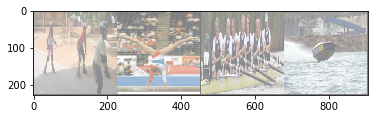

Process Process-54:
Traceback (most recent call last):
Process Process-55:
Process Process-53:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/key/software/anaconda3/envs/pt3.5/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/key/software/anaconda3/envs/pt3.5/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/key/software/anaconda3/envs/pt3.5/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/key/software/anaconda3/envs/pt3.5/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/key/software/anaconda3/envs/pt3.5/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
  File "/home/key/software/anaconda3/envs/pt3.5/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  F

In [47]:
dataiter = iter(dataloaders["test"])
images, labels = dataiter.next()

# print images
imshow(utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [58]:
outputs = cnn(Variable(images))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j,0]]  for j in range(4)))


Predicted:  xc_skiing xc_skiing xc_skiing xc_skiing


In [85]:
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
for data in dataloaders["test"]:
    image, label = data
    outputs = cnn(Variable(image))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == label).squeeze()
    class_correct[label[0]] += int(c[0])
    class_total[label[0]] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


/home/key/software/anaconda3/envs/pt3.5/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 3. 
  warnings.warn(str(msg))


NameError: name 'classes' is not defined

In [75]:
label[0]

5